In [15]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt


import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm

# Import the single DOF finite difference model
from mlp_singledof import MLP, MLPProjectionFilter



/home/alinjar/simple_training_warm_start/Simple_MLP


In [16]:
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, inp, theta_init, v_start):
        # input
        self.inp = inp 
        self.theta_init = theta_init
        self.v_start = v_start
        

    def __len__(self):
        return len(self.inp)    

    def __getitem__(self, idx):
        # Input
        inp = self.inp[idx]
        theta_init = self.theta_init[idx]
        v_start = self.v_start[idx]
        

        return (torch.tensor(inp).float(),
                torch.tensor(theta_init).float(),
                torch.tensor(v_start).float())
                

In [17]:
def sample_uniform_trajectories(key, var_min, var_max, dataset_size, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=var_min,
        high=var_max,
        size=(dataset_size, nvar)
    )
    return xi_samples, rng

In [18]:
#Parameters for MLP model

num_batch = 1000
num_dof=1
num_steps=20
timestep=0.05
v_max=1.0
a_max=2.0
j_max=4.0
p_max=180.0*np.pi/180.0 
maxiter_projection = 5
nvar_single = num_steps
nvar = num_dof * nvar_single
theta_init_min=-np.pi
theta_init_max=np.pi

In [19]:
#calculating number of constraints
num_acc = num_steps - 1
num_jerk = num_acc - 1
num_pos = num_steps
num_vel_constraints = 2 * num_steps * num_dof
num_acc_constraints = 2 * num_acc * num_dof
num_jerk_constraints = 2 * num_jerk * num_dof
num_pos_constraints = 2 * num_pos * num_dof
num_total_constraints = (num_vel_constraints + num_acc_constraints + 
                            num_jerk_constraints + num_pos_constraints)




In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

#### creating dataset

dataset_size = num_batch*30 #200000

theta_init, rng_theta_init = sample_uniform_trajectories(41, var_min= theta_init_min, var_max = theta_init_max, dataset_size=dataset_size, nvar=1)

theta_init_val, rng_theta_init_val = sample_uniform_trajectories(1, var_min= theta_init_min, var_max = theta_init_max, dataset_size=dataset_size, nvar=1)

v_start, rng_v_start = sample_uniform_trajectories(40, var_min =-1.0*v_max, var_max = 1.0*v_max, dataset_size=dataset_size, nvar=1)

v_start_val, rng_v_start_val = sample_uniform_trajectories(2, var_min =-1.0*v_max, var_max = 1.0*v_max, dataset_size=dataset_size, nvar=1)
#print("v_start", v_start.shape)

#For training
xi_samples, rng = sample_uniform_trajectories(42, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)

#For validation
xi_val, rng_val = sample_uniform_trajectories(43, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)

# xi_samples = torch.from_numpy(xi_samples)
# xi_val = torch.from_numpy(xi_val)

inp = np.hstack(( xi_samples, theta_init, v_start))

inp_val = np.hstack(( xi_val, theta_init_val, v_start_val))

Using cuda device


In [21]:
print("inp_mean", inp.mean())
print("inp_std", inp.std())

inp_mean -0.0006183883359578748
inp_std 0.682808147452024


In [22]:

# A Torch version of the same is used in decoder function of corresponding MLP class for training
#Statistical Parameters:Median, Q1, Q3, IQR for all features

inp_median_ = np.median(inp, axis=0)
inp_q1 = np.percentile(inp, 25, axis=0)
inp_q3 = np.percentile(inp, 75, axis=0)
inp_iqr_ = inp_q3 - inp_q1


# Handle constant features
inp_iqr_ = np.where(inp_iqr_ == 0, 1, inp_iqr_)

print("input shape: ", inp.shape)
print(inp_median_.shape)
print(inp_q1.shape)
print(inp_q3.shape)
print(inp_iqr_.shape)

# print(np.array_repr(inp_median_))
# print(np.array_repr(inp_iqr_))


inp_val_median_ = np.median(inp_val, axis=0)
inp_val_q1 = np.percentile(inp_val, 25, axis=0)
inp_val_q3 = np.percentile(inp_val, 75, axis=0)
inp_val_iqr_ = inp_val_q3 - inp_val_q1


# Handle constant features
inp_val_iqr_ = np.where(inp_val_iqr_ == 0, 1, inp_val_iqr_)

print("input shape: ", inp_val.shape)
print(inp_val_median_.shape)
print(inp_val_q1.shape)
print(inp_val_q3.shape)
print(inp_val_iqr_.shape)

# print(np.array_repr(inp_median_))
# print(np.array_repr(inp_iqr_))



input shape:  (30000, 22)
(22,)
(22,)
(22,)
(22,)
input shape:  (30000, 22)
(22,)
(22,)
(22,)
(22,)


In [23]:
# Using PyTorch Dataloader
train_dataset = TrajDataset(inp, theta_init, v_start)
val_dataset = TrajDataset(inp_val, theta_init_val, v_start_val)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)


In [24]:

enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints #( xi_samples- 0:nvar, lamda_smples- nvar:2*nvar)

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)

In [25]:


model = MLPProjectionFilter(mlp=mlp, num_batch = num_batch,num_dof=num_dof,num_steps=num_steps,
							timestep=timestep,v_max=v_max,a_max=a_max,j_max=j_max,p_max=p_max, 
							maxiter_projection=maxiter_projection).to(device)

print(type(model))                            

<class 'mlp_singledof.MLPProjectionFilter'>


In [26]:
epochs = 100
#step, beta = 0, 1.0 # 3.5
optimizer = optim.AdamW(model.parameters(), lr = 1e-4, weight_decay=6e-5)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1, verbose=True)

losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_projection_loss = [], [], [], []
avg_val_loss = []
for epoch in range(epochs):
    
    # Train Loop
    losses_train, primal_losses, fixed_point_losses, projection_losses = [], [], [], []
    
    for (inp, theta_init, v_start) in tqdm(train_loader):
        
        # Input and Output 
        inp = inp.to(device)
        theta_init = theta_init.to(device)
        v_start = v_start.to(device)
        
        xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
        accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp, theta_init, v_start)

        xi_samples_inp = inp[:, :nvar]

        primal_loss, fixed_point_loss, projection_loss, loss = model.mlp_loss(accumulated_res_primal, 
                                                                              accumulated_res_fixed_point, xi_samples_inp, xi_projected)

        
        optimizer.zero_grad() #clears the gradients of the model parameters
        loss.backward() #computes the gradients of the model parameters
        
        
        # #Gradient Norm check
        # total_norm = 0.0
        # for p in model.parameters():
        #     if p.grad is not None:
        #         param_norm = p.grad.data.norm(2)  # L2 norm
        #         total_norm += param_norm.item() ** 2

        # total_norm = total_norm ** 0.5
        # print(f"Gradient L2 norm: {total_norm:.4f}")
        
        ##Gradient Norm clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


        optimizer.step() #updates the model parameters (e.g. weights and biases)
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        projection_losses.append(projection_loss.detach().cpu().numpy())
        
    if epoch % 2 == 0:
        
        # Validation 
        model.eval()
        val_losses = []

        with torch.no_grad():
            for (inp_val, theta_init, v_start) in tqdm(val_loader):
                inp_val = inp_val.to(device)
                theta_init = theta_init.to(device)
                v_start = v_start.to(device)

                xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
                accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp_val, theta_init, v_start)

                xi_samples_inp_val = inp_val[:, :nvar]

                _, _, _, val_loss = model.mlp_loss(
                    accumulated_res_primal, accumulated_res_fixed_point, xi_samples_inp_val, xi_projected
                )

                val_losses.append(val_loss.detach().cpu().numpy())

                #print(f"Validation Loss: {np.average(val_losses):.4f}")
            

    if epoch % 2 == 0:    
        print(f"Epoch: {epoch + 1}")
        print(f"Train Loss: {np.average(losses_train):.4f}")
        


    #step += 0.07 #0.15
    #scheduler.step()

    # mean_train_loss = np.mean(losses_train)
    # mean_val_loss = np.mean(val_losses)
    
    os.makedirs("./training_weights", exist_ok=True)
    #if mean_val_loss <= last_loss:
    if loss <= last_loss:
            torch.save(model.state_dict(), f"./training_weights/mlp_learned_single_dof.pth")
            last_loss = loss

    avg_train_loss.append(np.average(losses_train)), avg_primal_loss.append(np.average(primal_losses)), \
    avg_projection_loss.append(np.average(projection_losses)), avg_fixed_point_loss.append(np.average(fixed_point_losses))
    avg_val_loss.append(np.average(val_losses))


100%|██████████| 30/30 [00:00<00:00, 102.39it/s]


Epoch: 1
Train Loss: 3.4029


100%|██████████| 30/30 [00:00<00:00, 96.82it/s] 


Epoch: 3
Train Loss: 2.5608


100%|██████████| 30/30 [00:00<00:00, 80.23it/s] 


Epoch: 5
Train Loss: 2.0126


100%|██████████| 30/30 [00:00<00:00, 98.69it/s] 


Epoch: 7
Train Loss: 1.5986


100%|██████████| 30/30 [00:00<00:00, 101.19it/s]


Epoch: 9
Train Loss: 1.2903


100%|██████████| 30/30 [00:00<00:00, 82.31it/s] 


Epoch: 11
Train Loss: 1.0640


100%|██████████| 30/30 [00:00<00:00, 99.11it/s] 


Epoch: 13
Train Loss: 0.9430


100%|██████████| 30/30 [00:00<00:00, 101.98it/s]


Epoch: 15
Train Loss: 0.8013


100%|██████████| 30/30 [00:00<00:00, 101.40it/s]


Epoch: 17
Train Loss: 0.7306


100%|██████████| 30/30 [00:00<00:00, 81.27it/s]


Epoch: 19
Train Loss: 0.6962


100%|██████████| 30/30 [00:00<00:00, 101.38it/s]


Epoch: 21
Train Loss: 0.6677


100%|██████████| 30/30 [00:00<00:00, 102.22it/s]


Epoch: 23
Train Loss: 0.6499


100%|██████████| 30/30 [00:00<00:00, 79.80it/s]


Epoch: 25
Train Loss: 0.5973


100%|██████████| 30/30 [00:00<00:00, 80.65it/s]


Epoch: 27
Train Loss: 0.5841


100%|██████████| 30/30 [00:00<00:00, 101.70it/s]


Epoch: 29
Train Loss: 0.5758


100%|██████████| 30/30 [00:00<00:00, 78.53it/s]


Epoch: 31
Train Loss: 0.5824


100%|██████████| 30/30 [00:00<00:00, 80.64it/s]


Epoch: 33
Train Loss: 0.5693


100%|██████████| 30/30 [00:00<00:00, 98.85it/s] 


Epoch: 35
Train Loss: 0.5676


100%|██████████| 30/30 [00:00<00:00, 96.22it/s]


Epoch: 37
Train Loss: 0.5590


100%|██████████| 30/30 [00:00<00:00, 79.25it/s] 


Epoch: 39
Train Loss: 0.5578


100%|██████████| 30/30 [00:00<00:00, 100.41it/s]


Epoch: 41
Train Loss: 0.5647


100%|██████████| 30/30 [00:00<00:00, 100.15it/s]


Epoch: 43
Train Loss: 0.5604


100%|██████████| 30/30 [00:00<00:00, 77.71it/s]


Epoch: 45
Train Loss: 0.5626


100%|██████████| 30/30 [00:00<00:00, 74.25it/s]


Epoch: 47
Train Loss: 0.5522


100%|██████████| 30/30 [00:00<00:00, 95.16it/s]


Epoch: 49
Train Loss: 0.5551


100%|██████████| 30/30 [00:00<00:00, 97.77it/s]


Epoch: 51
Train Loss: 0.5633


100%|██████████| 30/30 [00:00<00:00, 77.58it/s]


Epoch: 53
Train Loss: 0.5543


100%|██████████| 30/30 [00:00<00:00, 101.37it/s]


Epoch: 55
Train Loss: 0.5585


100%|██████████| 30/30 [00:00<00:00, 101.18it/s]


Epoch: 57
Train Loss: 0.5515


100%|██████████| 30/30 [00:00<00:00, 79.99it/s] 


Epoch: 59
Train Loss: 0.5640


100%|██████████| 30/30 [00:00<00:00, 79.50it/s]


Epoch: 61
Train Loss: 0.5503


100%|██████████| 30/30 [00:00<00:00, 100.27it/s]


Epoch: 63
Train Loss: 0.5524


100%|██████████| 30/30 [00:00<00:00, 100.84it/s]


Epoch: 65
Train Loss: 0.5529


100%|██████████| 30/30 [00:00<00:00, 80.45it/s] 


Epoch: 67
Train Loss: 0.5514


100%|██████████| 30/30 [00:00<00:00, 101.17it/s]


Epoch: 69
Train Loss: 0.5511


100%|██████████| 30/30 [00:00<00:00, 101.14it/s]


Epoch: 71
Train Loss: 0.5493


100%|██████████| 30/30 [00:00<00:00, 80.34it/s] 


Epoch: 73
Train Loss: 0.5418


100%|██████████| 30/30 [00:00<00:00, 100.96it/s]


Epoch: 75
Train Loss: 0.5444


100%|██████████| 30/30 [00:00<00:00, 102.41it/s]


Epoch: 77
Train Loss: 0.5507


100%|██████████| 30/30 [00:00<00:00, 100.04it/s]


Epoch: 79
Train Loss: 0.5473


100%|██████████| 30/30 [00:00<00:00, 79.83it/s]


Epoch: 81
Train Loss: 0.5546


100%|██████████| 30/30 [00:00<00:00, 101.94it/s]


Epoch: 83
Train Loss: 0.5428


100%|██████████| 30/30 [00:00<00:00, 100.72it/s]


Epoch: 85
Train Loss: 0.5456


100%|██████████| 30/30 [00:00<00:00, 81.32it/s] 


Epoch: 87
Train Loss: 0.5518


100%|██████████| 30/30 [00:00<00:00, 79.05it/s]


Epoch: 89
Train Loss: 0.5448


100%|██████████| 30/30 [00:00<00:00, 102.60it/s]


Epoch: 91
Train Loss: 0.5460


100%|██████████| 30/30 [00:00<00:00, 79.53it/s] 


Epoch: 93
Train Loss: 0.5472


100%|██████████| 30/30 [00:00<00:00, 78.55it/s]


Epoch: 95
Train Loss: 0.5427


100%|██████████| 30/30 [00:00<00:00, 101.55it/s]


Epoch: 97
Train Loss: 0.5458


100%|██████████| 30/30 [00:00<00:00, 101.83it/s]


Epoch: 99
Train Loss: 0.5441


100%|██████████| 30/30 [00:00<00:00, 63.46it/s]


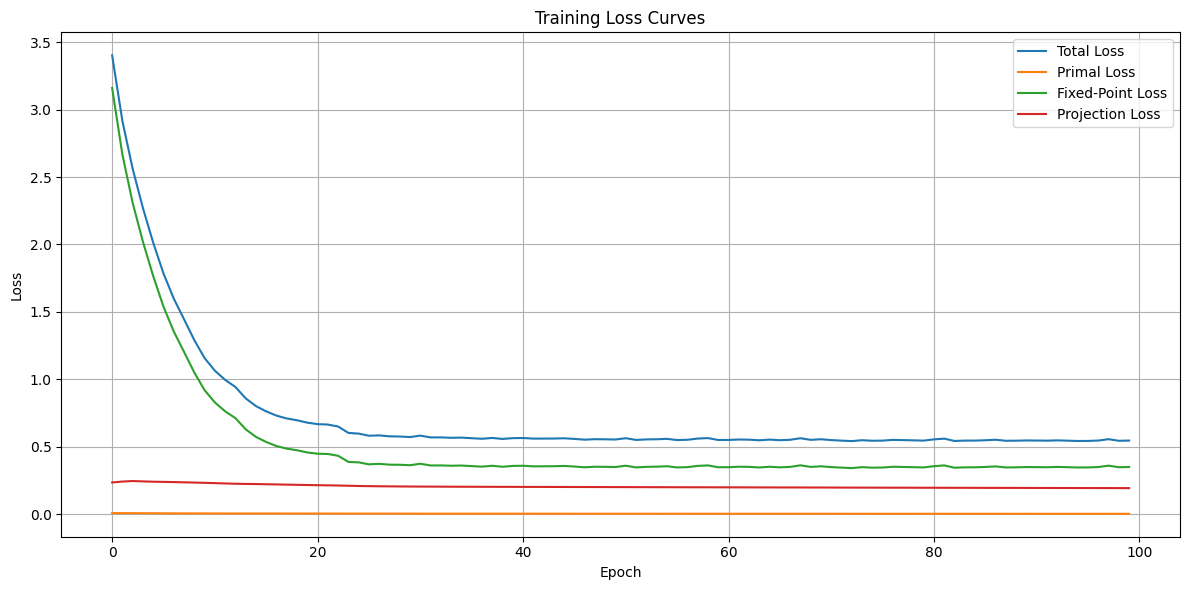

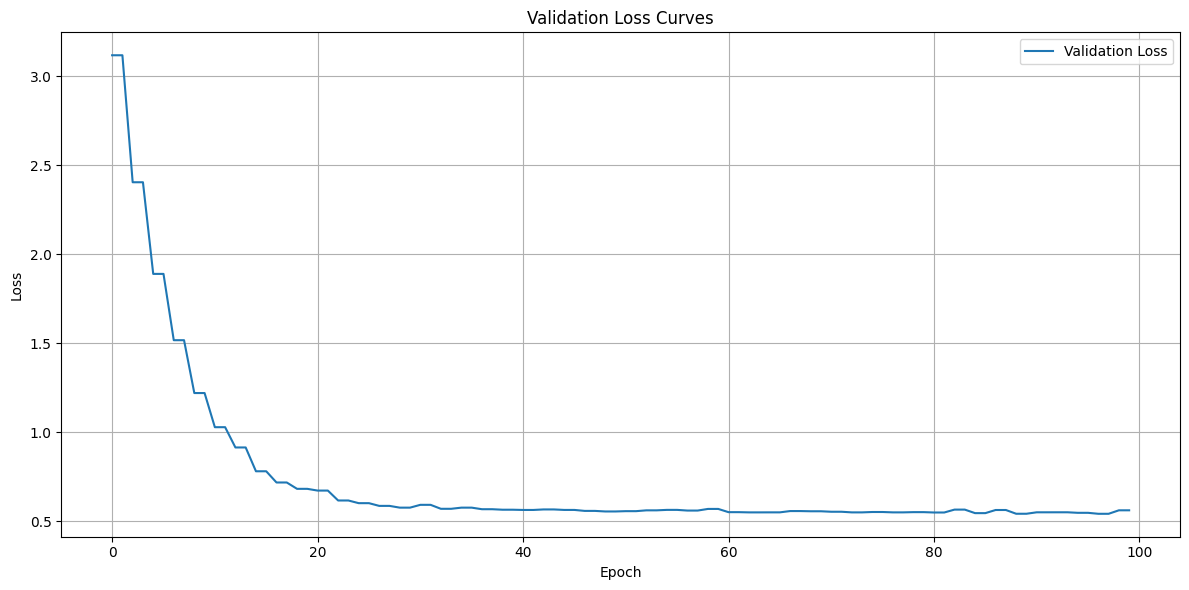

In [27]:
# Plot training losses

plt.figure(figsize=(12, 6))

plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_projection_loss, label='Projection Loss')


plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss, label='Validation Loss')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
avg_train_loss = np.asarray(avg_train_loss)
avg_val_loss = np.asarray(avg_val_loss)
print("Training_loss_end", avg_train_loss[-1])
print("Validation_loss_end", avg_val_loss[-1])

print("max projection_loss", np.max(np.asarray(avg_projection_loss)))
print("min projection_loss", np.min(np.asarray(avg_projection_loss)))

Training_loss_end 0.54584724
Validation_loss_end 0.56050754
max projection_loss 0.24560407
min projection_loss 0.19313408
